### Neste exemplo, implementamos a versão em batelada do gradiente descendente para o treinamento de um regressor logístico.

In [1]:
# Import all necessary libraries.
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from scipy.special import expit # implementação da função logística
import matplotlib.pyplot as plt

In [2]:
# Reset the PN sequence generator.
seed = 42
np.random.seed(seed)

### Gerando os dados de 2 classes.

In [3]:
# Number of examples.
N = 1000

# Create a 2-class dataset for classification with the specified centers.
centers = [[-5.0, 0], [0, 5.0]]

# Generate Gaussian blobs for classification.
X, y = make_blobs(n_samples=N, centers=centers, random_state=seed)

### Plotando as 2 classes.

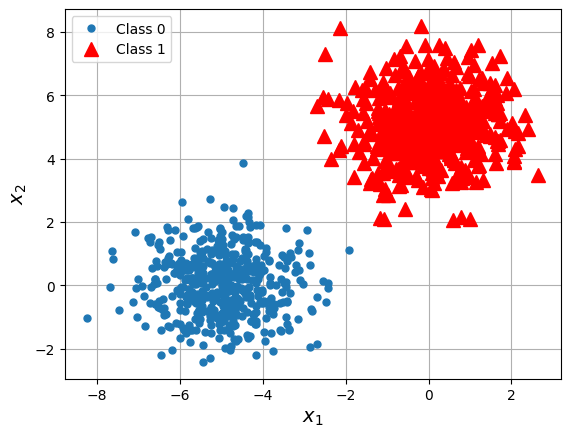

In [4]:
# Obtendo os índices das classes 0 e 1 para plotar exemplos com cores diferentes.
idx0 = np.argwhere(y == 0)
idx1 = np.argwhere(y == 1)

fig = plt.figure()
plt.plot(X[idx0,0], X[idx0,1], '.', markersize=10, label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'r^', markersize=10, label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.legend()
plt.grid()
plt.show()

#### Qual o formato mais apropriado (i.e., mais simples) para a função discriminante?

### Definindo a classe de regressão logística com gradiente descendente em batelada.

In [5]:
class logisticRegressorWithGD():
    '''Logistic regression with gradient descent.'''

    def __init__(self, alpha=0.1, numEpochs=1):
        '''Construtor da classe logisticRegressorWithGD.'''
        # Incialização dos atributos da classe.
        self.alpha = alpha
        self.numEpochs = numEpochs
        self.a = 0
        self.a_min = 0

    def hypothesis(self, X):
        '''Função hipótese.
           Retorna as probabilidades dos exemplos de entrada.'''
        # Função discriminante em formato matricial.
        g = X.dot(self.a)
        # Função de limiar de decisão sigmóide.
        h = expit(g)
        return h

    def predict(self, X):
        '''Função que classifica (predição) os exemplos de entrada.
           Retorna a classe do exemplo de entrada.'''
        h = self.hypothesis(X)
        # Laço de repetição usado para quantizar os valores de saída da função hipótese.
        c = np.zeros((len(h), 1))
        for i in range(0, len(h)):
            if(h[i] >= 0.5):
                c[i,0] = 1.0
        return c

    def error_function(self, X, y):
        '''Função usada para calcular o erro médio cometido pelo regressor logístico.'''
        h = self.hypothesis(X)
        error = -(1/len(y))*np.sum(y*(np.log(h)) + (1-y)*(np.log((1-h))))
        return error

    def fit(self, X_train, y_train, X_test, y_test):
        '''Batch gradient descent solution.'''

        # Number of training examples.
        N = len(y_train)

        # Reshaping into column vectors.
        y_train = y_train.reshape(N, 1)
        y_test = y_test.reshape(len(y_test), 1)

        # Random initialization of parameters.
        self.a = np.random.randn(X_train.shape[1], 1)

        # Create array for storing error values.
        Jgd = np.zeros(self.numEpochs+1)
        Jgd_v = np.zeros(self.numEpochs+1)

        # Calculate initial error.
        Jgd[0] = self.error_function(X_train, y_train)
        Jgd_v[0] = self.error_function(X_test, y_test)

        # Gradient-descent loop.
        minimum_val_error = float("inf")
        iteration = 0
        while iteration < self.numEpochs:
            # Calculate the gradient vector.
            gradients = -(1/N)*X_train.T.dot(y_train - self.hypothesis(X_train))

            # Update weights.
            self.a = self.a - self.alpha*gradients

            # Calculating training and validation errors.
            Jgd[iteration+1] = self.error_function(X_train, y_train)
            Jgd_v[iteration+1] = self.error_function(X_test, y_test)

            # Early-stop: store weights for the smallest error ever.
            if(Jgd_v[iteration+1] < minimum_val_error):
                minimum_val_error = Jgd_v[iteration+1]
                self.a_min = self.a

            # Update iteration number.
            iteration = iteration + 1

        return Jgd, Jgd_v, iteration, self.a_min, minimum_val_error, self.a

### Dividindo os dados em conjuntos de treinamento e validação.

**OBS**: 70% das amostras são deixadas no conjunto de treinamento e o restante vai para o conjunto de validação.

In [6]:
# Split array into random train and validation subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

print('Dimensão do conjunto de treinamento:', X_train.shape)
print('Dimensão do conjunto de validação:', X_test.shape)

Dimensão do conjunto de treinamento: (700, 2)
Dimensão do conjunto de validação: (300, 2)


### Alterando as matrizes de atributos de treinamento e validação para que implementem o formato apropriado da função discriminante.

O formato apropriado (i.e., mais simples) é o de uma reta, conforme mostrado abaixo.

$$g(\textbf{x}(i)) = \hat{a}_0 + \hat{a}_1x_1(i) + \hat{a}_2x_2(i), \forall i$$

onde $\hat{a}_0$ é o peso de bias e o atributo correspondente, $x_0(i)$, é sempre feito igual a 1.

Em formato matricial, levando em conta todos os exemplos, a função discriminante é definida como

$$\textbf{g}(\textbf{X}) = \textbf{X}\hat{\textbf{a}},$$

onde $\hat{\textbf{a}}$ e $\textbf{X}$ são um vetor coluna (com dimensão $K+1 \times 1$) e uma matriz (com dimensão $N \times K+1$), respectivamente.

**OBS**: Como `X_train` e `X_test` já são matrizes com os atributos $x_1$ e $x_2$, nós só precisamos concatená-las com o vetor do atributo de bias, $x_0$.

In [7]:
# Add bias to feature matrix.
X_train = np.c_[np.ones((len(y_train), 1)), X_train]

# Add bias to feature matrix.
X_test = np.c_[np.ones((len(y_test), 1)), X_test]

### Treinando o classificador.

In [8]:
# learning rate.
alpha = 0.1

# Maximum number of iterations.
numEpochs = 1000

# Instantiate Logistic classifier.
classifier = logisticRegressorWithGD(alpha, numEpochs)

# Train the model.
Jgd, Jgd_v, iteration, a_min, minimum_val_error, a = classifier.fit(X_train, y_train, X_test, y_test)

# Print smallest error.
print('minimum_val_error', minimum_val_error)

minimum_val_error 0.003855790777384735


### Plotando os erros em função das iterações.

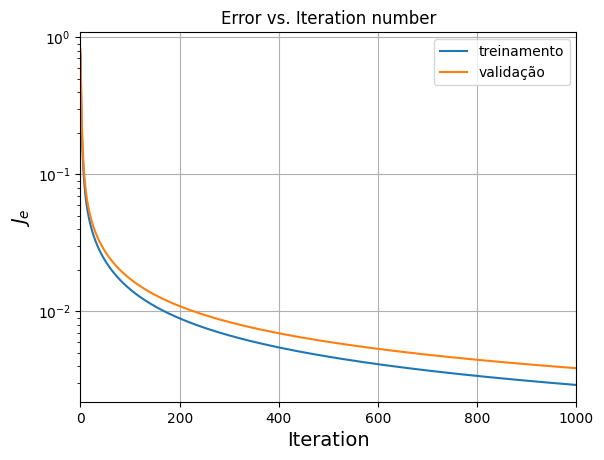

In [9]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.yscale('log')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Error vs. Iteration number')
plt.legend()
plt.grid()
plt.show()

### Calculando a acurácia do classificador.

**OBS**.: Podemos usar a função `accuracy_score` da biblioteca SciKit-Learn para calcular a acurácia.

In [10]:
# Calculate accuracy of class predictions.
y_pred = classifier.predict(X_test)

# SciKit-Learn's function. Imported from the metric's module.
acc = accuracy_score(y_test, y_pred)
print('Acurácia:', acc)

Acurácia: 1.0


### Plotando as regiões de decisão.

**OBS:**

+ Devido à saída do regressor logístico ser a probabilidade de um exemplo de entrada pertencer à classe positiva, a **transição entre as classes se torna suave**.
+ Notem que a matriz de atributos criada para plotarmos as regiões de decisão também deve ter o **mesmo formato que as matrizes de atributos** criadas para o treinamento e validação.

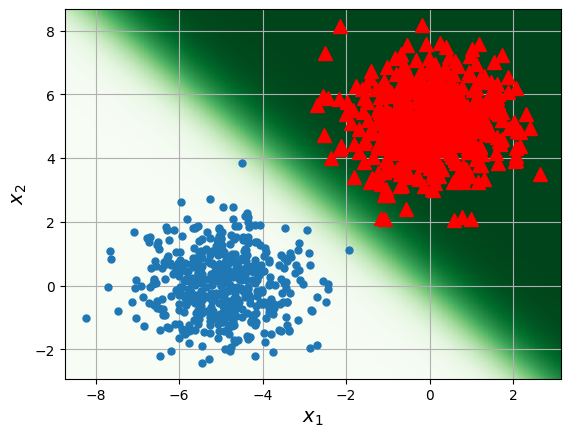

In [11]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

# Probabilities as output.
Z = classifier.hypothesis(attribute_matrix)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', markersize=10, label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'r^', markersize=10, label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()

plt.show()

+ A figura abaixo mostra a fronteira de decisão quando se quantiza os valores de saída do regressor logístico, fazendo com que a **transição entre as classes seja abrupta**.
</br>

+ A **transição** entre as classes é **definida pela fronteira de decisão**, a qual é traçada exatamente ao longo dos pontos onde a função discriminante é igual a 0, ou seja, ao longos dos pontos que o modelo prediz uma probabilidade de 50% para ambas as classes.

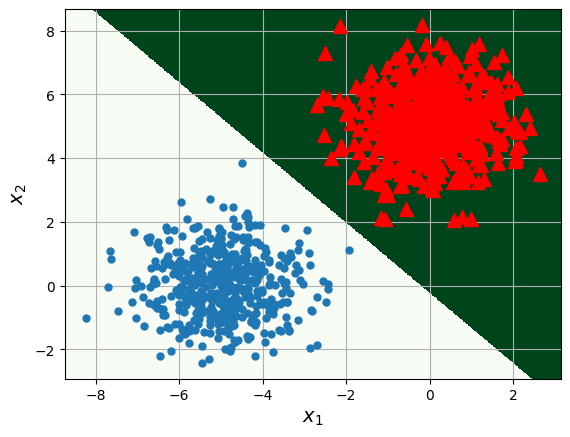

In [12]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

# Quantization of the classifier's output.
Z = classifier.predict(attribute_matrix)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', markersize=10, label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'r^', markersize=10, label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()

plt.show()

### Plotando a matriz de confusão.

Uma métrica muito comum para verificar o desempenho de classificadores é a matriz de confusão.

Através dela, podemos extrair várias métricas de desempenho, como veremos mais adiante.

Vejamos o exemplo abaixo. As diferentes cores indicam a quantidade de exemplos num dado grupo, quanto mais escura for a cor, maior o número de exemplos naquele grupo.

Um classificador perfeito tem apenas valores diferentes de zero na diagonal principal da matriz.

Valores diferentes de zero fora da diagonal principal indicam classificações incorretas.

<img src="https://github.com/zz4fap/t320_aprendizado_de_maquina/blob/main/figures/matriz_de_confus%C3%A3o.png?raw=1" width="600px">

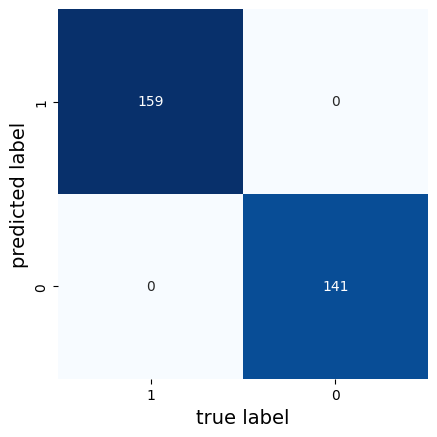

In [13]:
# Plot the confusion matrix. SciKit-Learn's function from metric's module.
mat = confusion_matrix(y_test, y_pred)
# square: deixa a figura quadrada.
# annot: imprime a quantidade de exemplos em cada classe.
# fmt: imprime quantidade de exemplos em formato decimal.
# cbar: habilita a adição de uma barra de cores.
# xticklabels e yticklabels: rótulos dos eixos x e y, respectivamente.
# cmap: estilo de cores usado para plotar a matriz.
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['1','0'], yticklabels=['1','0'], cmap="Blues")
plt.xlabel('true label', fontsize=14)
plt.ylabel('predicted label', fontsize=14)
plt.show()

### Comparação entre a regressão logística e a regra de aprendizagem do perceptron.

+ Lembrem-se que nós não definimos uma função de erro quando usamos a regra de aprendizagem do perceptron.
+ Naquele caso, **não existe uma função de erro** a ser minimizada.
+ O objetivo da regra é encontrar uma **separação perfeita** das classes, ou seja, encontrar um erro igual a 0.
+ E é por isso que ela nunca converge quando é utilizado com classes que se sobrepõem.
<br/><br/>

+ Entretanto, no caso do regressor logístico, nós **definimos uma função de erro**.
+ O objetivo nesse caso é **minimizar o erro**, ou seja, encontrar o menor erro possível, o qual pode ser diferente de 0.
+ Percebam então, que o objetivo não é encontrar uma separação perfeita entre as classes e sim **o menor erro possível**.
+ E é por isso que ela converge para um valor de erro, mesmo com classes que se sobrepõem.